In [90]:
import os

# Ignore numpy warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%matplotlib notebook

# Use seaborn settings.
import seaborn as sns
sns.set(
        #context="paper",
        context="talk",
        #context="poster",
        style='darkgrid',
        #style="dark",
        #palette='deep',
        font='sans-serif', 
        #font_scale=1.0, 
        #color_codes=False, 
        rc={'figure.figsize': (12, 8.0)}, # width and height in inches.
)

import IPython

def _embed(src, width="800", height="400"):
    return IPython.display.IFrame(src=src, width=str(width), height=str(height))

from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

@register_line_magic
def embed(line):
    "my line magic"
    #return line
    return _embed(line)


# We delete these to avoid name conflicts for automagic to work
del embed
#del lcmagic

# Theme
# import jtplot module in notebook
#from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='monokai')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
#jtplot.reset()

from abipy import abilab
import abipy.data as abidata

si_pseudo = os.path.join(abidata.pseudo_dir, "14si.pspnc")

# Technical aspects related to high-throughput calculations with ABINIT

### M. Giantomassi and the AbiPy group

9th international ABINIT developer workshop 20-22nd May 2019 - Louvain-la-Neuve, Belgium

<!-- link rel="stylesheet" href="reveal.js/css/theme/sky.css" id="theme" -->

<img src="./assets/intro_logos.png" width="85%" heigh="15%" align="center">

<hr> 

* These slides have been generated using [jupyter](https://jupyter.org), [nbconvert](https://github.com/jupyter/nbconvert) and [revealjs](https://revealjs.com/)

* The notebook can be downloaded from this [github repo](https://github.com/gmatteo/abipy_htc_technical_aspects_abidev2019)

* To install and configure the software, follow these [installation instructions](https://github.com/abinit/abipy#getting-abipy)

Use the Space key to navigate through all slides.

<!--
In this talk, I will present the approach employed in AbiPy to implement automatic ABINIT calculations. More specifically, I will discuss how we employ
YAML and netcdf files to exchange information between Fortran and Python,
the logic used in AbiPy to parallelize and optimize calculations at runtime and
the protocol used to handle possible errors during the ab-initio computation. I
will also discuss how to use the Fortran API of ABINIT to generate netcdf files
that can interoperate seamlessly with our high-throughput infrastructure. In the
last part, I will present some of the technical problems we are still facing and
discuss possible approaches to address these issues.
-->







<img src="./assets/abipy_logo.jpg" width="55%" align="center">

## What is AbiPy?

#### Python package for:

   * Generating ABINIT input files automatically
   * Post-processing output results (*netcdf* and *text* files)
   * Interfacing ABINIT with external tools (e.g. [Vesta](http://jp-minerals.org/vesta/en/))
   * Creating and executing workflows (band structures, phonons, $GW$…)
   
#### Project:

* Developed and maintained by the ABINIT community
* Used by developers to validate, profile and optimize ABINIT
* Hosted on [github](https://github.com/abinit/abipy) 
* Release under the GPLv2 license

## Why python?

   * Easy to use and to learn
   * Great support for science ([numpy](http://www.numpy.org/), [scipy](https://www.scipy.org/), [pandas](http://pandas.pydata.org/), [matplotlib](https://matplotlib.org/) …)
   * Interactive environments ([ipython](http://ipython.org/), [jupyter notebooks](https://jupyter.org/), GUIs)
   * More powerful and flexible than Fortran for implementing the high-level logic needed in modern ab-initio workflows
   * [pymatgen](https://github.com/materialsproject) ecosystem and the [materials project database](https://www.materialsproject.org/)…

## What do we need to automate calculations?

* Tools to parse and analyze output results
* python API to generate input files
* High-level logic for:

    * Managing complicated workflows
    * Exposing task parallelism (independent steps can be executed in parallel)
    * Handling runtime errors and restarting calculations
    * Saving final results in machine-readable format (e.g. databases)

<img src="./assets/sdata201865-f2.jpg" width="50%" align="center">

<hr>

### Let's discuss the different parts step by step…

## AbiPy design principles

* Extend the pymatgen code-base with ABINIT-specific objects
* Layered structure designed for different use-cases:
        
     * Post-processing tools and command-line interfaces
     * API to automate calculations and data analysis
     * High-throughput infrastructure ([abiflows](https://github.com/abinit/abiflows), [fireworks](https://github.com/materialsproject/fireworks), [mongodb](https://www.mongodb.com/))
     
* Closely connected to the ABINIT executable:

    * CPU-intensive algorithms performed by ABINIT (Fortran + MPI + OpenMP)
    * Glue code implemented in python
   


## Workflow infrastructure

Two different approaches:

#### AbiPy workflows:

   * Lightweight implementation (*pymatgen* + *AbiPy*)
   * No database required. Object persistence provided by [*pickle*](https://docs.python.org/3/library/pickle.html)
   * Ideal tool for prototyping 
    
    
#### AbiFlows workflows: 

   * Requires [MongoDb](https://www.mongodb.com/) database
   * Based on [fireworks](https://materialsproject.github.io/fireworks/)
   * Designed and optimized for <u>high-throughput applications</u>
   
<hr>

Both approaches share the same codebase (*AbinitInput*, factory functions, AbiPy objects).

Number and type of calculations are important ➝ choose the approach that suits to your needs.

* ABINIT and AbiPy communicate through Yaml docs and [netcdf](https://www.unidata.ucar.edu/software/netcdf/docs/) files

* AbiPy employs this "protocol" to generate input files, handle errors, implement high-level logic

## Why two formats for communicating?

* yaml docs

    * Small documents for error message with context
    * Used to access Abinit-computed quantities (*autoparal*, list of *perturbations*)
    * Extracted from log file 
    * Easy to write with plain Fortran write
        
* netcdf

    * Portable binary format implemented in C
    * Fortran/Python bindings and support for parallel MPI-IO (HDF5)
    * [ETSF-IO specifications](https://www.etsf.eu/fileformats) for crystalline structures, wavefunctions, densities…

## How do we understand that the job completed successfully?
<p></p>

```yaml
--- !FinalSummary
program: abinit
version: 8.11.6
start_datetime: Sat Mar 30 23:01:14 2019
end_datetime: Sat Mar 30 23:04:04 2019
overall_cpu_time:         168.8
overall_wall_time:         169.7
exit_requested_by_user: no 
timelimit: 0
pseudos: 
    Li  : 9517c0b7d24d4898578b8627ce68311d
    F   : 14cf65a61ba7320a86892d2f062b1f44
usepaw: 0
mpi_procs: 1
omp_threads: 1
num_warnings: 2
num_comments: 73
...
```

## Abort handled by the developer
<p></p>

#### Fortran

```fortran
 MSG_ERROR("Hello")
```

#### Yaml doc in log file

* src_file and str_line added by CPP preprocessor
* message: Informative string for user, may be used by AbiPy for quick fixes

#### Common runtime Errors

#### Common runtime errors are associated with additional metadata and actions performed by the code 

```fortran
    MSG_ERROR_CLASS(dilatmx_errmsg, "DilatmxError")
```


```fortran
! check dilatmx here and correct if necessary
 if (usewvl == 0) then
   call chkdilatmx(dt_chkdilatmx,dilatmx,rprimd,rprimd_orig,dilatmx_errmsg)
   _IBM6("dilatxm_errmsg: "//TRIM(dilatmx_errmsg))
   if (LEN_TRIM(dilatmx_errmsg) /= 0) then
     MSG_WARNING(dilatmx_errmsg)
     nerr_dilatmx = nerr_dilatmx+1
     if (nerr_dilatmx > 3) then
       ! Write last structure before aborting, so that we can restart from it.
       ! zion is not available, but it's not useful here.
       if (me == master) then
         ! Init crystal
         hist%ihist = abihist_findIndex(hist,-1)
         call hist2var(acell,hist,ab_mover%natom,rprimd,xred,DEBUG)
         call crystal_init(amu_curr,crystal,0,ab_mover%natom,&
           npsp,ab_mover%ntypat,ab_mover%nsym,rprimd,ab_mover%typat,xred,&
           [(-one, ii=1,ab_mover%ntypat)],ab_mover%znucl,2,.False.,.False.,"dilatmx_structure",&
           symrel=ab_mover%symrel,tnons=ab_mover%tnons,symafm=ab_mover%symafm)

#ifdef HAVE_NETCDF
         ! Write netcdf file
         filename = strcat(filnam_ds4, "_DILATMX_STRUCT.nc")
         NCF_CHECK(crystal%ncwrite_path(filename))
#endif
         call crystal%free()
       end if
       call xmpi_barrier(comm_cell)
       write (dilatmx_errmsg, '(a,i0,3a)') &
        'Dilatmx has been exceeded too many times (', nerr_dilatmx, ')',ch10, &
        'Restart your calculation from larger lattice vectors and/or a larger dilatmx'
       MSG_ERROR_CLASS(dilatmx_errmsg, "DilatmxError")
     end if
   else
     nerr_dilatmx=0
   end if
 end if
```

#### This function returns an *AbiFile* object provinding access to physical properties.

Conventions:

   * *abifile.structure* ➝ crystalline structure (subclass of pymatgen *Structure*)
   * *abifile.ebands* ➝ electron band energies
   * *abifile.ebands.kpoints* ➝ list of k-points (k-path, IBZ) 
   * *abifile.phbands* ➝ phonon frequencies and displacements
   
Several AbiPy objects provide *plot* methods returning [*matplotlib*](https://matplotlib.org/) figures

## Clean exit with *--timeline* and smart-io mode
<p></p>

```sh
cat job.sh

#!/bin/bash
#SBATCH --ntasks=48
#SBATCH --time=12:00:00

abinit -timelimit 12:00:00 < run.file > run.log 2> run.err
```

* Available for iterative algorithms (Relax, Scf, Nscf?)
* Compute wall-time required by one iteration, save intermediate results if timelimit is approaching
* Abipy will restart the job from the previous results
* timelimit and prtwf -1 to reduce IO-pressure and avoid disk-quota hell 

## Abipy Robots

* High-level interface to operate on <u>multiple files</u> with the same file extension

* Useful for:

     * convergence studies
     * producing multiple plots
     * building [Pandas dataframes](https://pandas.pydata.org/) (data in tabular format powered by python)

* Each *Robot* is associated to a file extension, *e.g.* 

     * GSR.nc ➝ *GsrRobot*
     * DDB ➝ *DdbRobot*
     
* *Robots* can be constructed from:

    1. List of filenames
    2. Directories and regular expressions
    
* Command line interface provided by the *abicomp.py* script:

* To generate notebook to compare multiple *GSR* files, use:

            abicomp.py gsr out1_GSR.nc  out2_GSR.nc --notebook

### Post-processing the DFPT results available in the MP database

* More than 1500 DFPT calculations done with abiflows ([Petretto et al.](https://www.nature.com/articles/sdata201865))
* Results available on the materials project website (including the *DDB* files) 

<hr>

Let's assume we want to reuse the raw data for our research work:

   * Handling 1500 tabs in the web browser is not feasible
   * We need a <u>programmatic</u> interface to automate stuff. 

With python we can easily connect the different parts of the puzzle:

* REST API to get the raw data (*DDB*) from the MP database
* Computation of phonons, thermodinamical properties, Born effective charges, dielectric tensor, IR spectrum with ABINIT
* Post-processing with AbiPy

For a more comprehensive discussion see this 
[abitutorial](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/ddb.ipynb)

<!--
The results for the rocksalt phase of MgO are available at https://materialsproject.org/materials/mp-1009129/
-->

# How to automate input file generation with AbiPy

<img src="./assets/automate_input_files.jpg" width="85%" align="center">

## *AbinitInput* object 

Programmatic interface to generate input files:

* *Dict-like* object storing ABINIT variables 
* Methods to set multiple variables (*e.g.* **k**-path from *structure*)
* Factory functions to generate input files with minimal effort

Can invoke ABINIT to get important parameters such as:

  * list of **k**-points in the IBZ
  * list of irreducible DFPT perturbations
  * list of possible configurations for MPI jobs (*npkpt*, *npfft*, *npband* …)
     
#### To build an input, we need a *structure* and a list of *pseudos*:

In [91]:
inp = abilab.AbinitInput(structure="si.cif", pseudos="14si.pspnc")

#### Low-level API (should look familiar to Abinit users):

In [92]:
inp["ecut"] = 8
"ecut" in inp

True

#### Use *set_vars* to set the value of several variables with a single call:

In [93]:
inp.set_vars(kptopt=1, ngkpt=[2, 2, 2],  
             shiftk=[0.0, 0.0, 0.0, 0.5, 0.5, 0.5]  # 2 shifts in one list
            );

#### althought it's much easier to use:

In [94]:
inp.set_autokmesh(nksmall=2)

{'ngkpt': array([2, 2, 2]),
 'kptopt': 1,
 'nshiftk': 4,
 'shiftk': array([[0.5, 0.5, 0.5],
        [0.5, 0. , 0. ],
        [0. , 0.5, 0. ],
        [0. , 0. , 0.5]])}

####  The method builds a homogeneous k-mesh from metavariables:

* *nksmall* is the number of divisions used to sample the smallest lattice vector
* *shiftk* is automatically selected from an internal database.

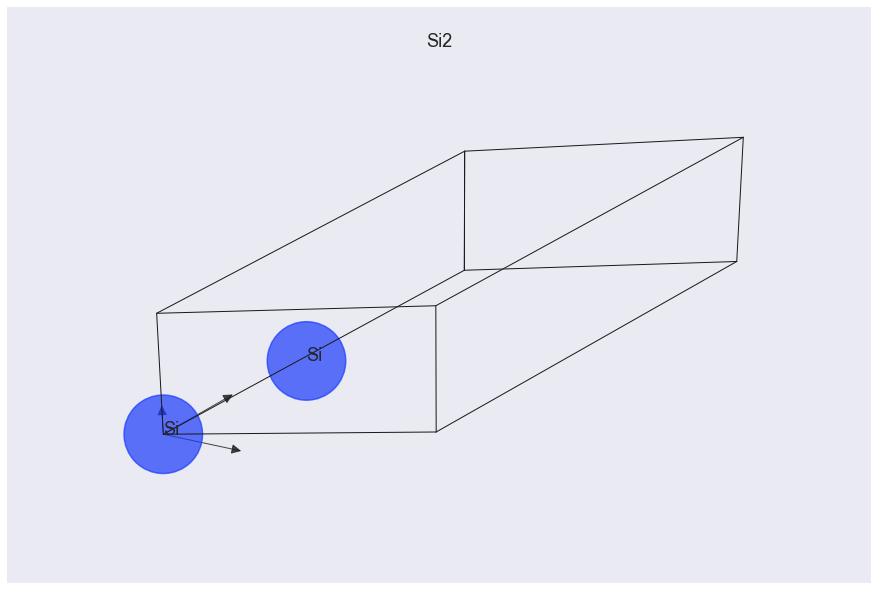

In [95]:
inp.structure.plot();

#### An *AbinitInput* has a structure object 

In [96]:
print(inp.structure.formula)

Si2


#### and a list of pseudopotentials

In [97]:
for pseudo in inp.pseudos:
    print(pseudo)

<NcAbinitPseudo: 14si.pspnc>
  summary: Troullier-Martins psp for element  Si        Thu Oct 27 17:31:21 EDT 1994
  number of valence electrons: 4.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 1.80626423934776
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


#### Pseudos from the [PseudoDojo project](http://www.pseudo-dojo.org/) provide hints for the cutoff energy.

In [98]:
#from pseudo_dojo.core.pseudos import OfficialDojoTable
#pseudo_table = OfficialDojoTable.from_dojodir('ONCVPSP-PBEsol-PDv0.4','standard')

#### Inside the notebook, one gets the HTML representation with links to the documentation:

In [99]:
inp

<AbinitInput at 120980950208>

#### To generate a high-symmetry k-path (taken from an internal database)

In [100]:
inp.set_kpath(ndivsm=10)

{'kptbounds': array([[0.   , 0.   , 0.   ],
        [0.5  , 0.   , 0.5  ],
        [0.5  , 0.25 , 0.75 ],
        [0.375, 0.375, 0.75 ],
        [0.   , 0.   , 0.   ],
        [0.5  , 0.5  , 0.5  ],
        [0.625, 0.25 , 0.625],
        [0.5  , 0.25 , 0.75 ],
        [0.5  , 0.5  , 0.5  ],
        [0.375, 0.375, 0.75 ],
        [0.625, 0.25 , 0.625],
        [0.5  , 0.   , 0.5  ]]), 'kptopt': -11, 'ndivsm': 10, 'iscf': -2}

* Ten points to sample the smallest segment of the **k**-path
* Other segments are sampled so that proportions are preserved

## Interfacing Abinit with Python via *AbinitInput*

* Once we have an *AbinitInput*, it is possible to execute Abinit to:

    * get useful information from the Fortran code (e.g. IBZ, space group…)
    * validate the input file before running the calculation 
        
* Methods invoking Abinit start with the *abi* prefix followed by a verb: 

    * *inp.abiget_irred_phperts(...)* 
    * *inp.abivalidate()*

#### Important: 

* To call Abinit from AbiPy, one has to prepare a configuration file (*manager.yml*)
  providing all the information required to execute/submit Abinit jobs: 

     * `$PATH`, `$LD_LIBRARY_PATH`
     * modules
     * python environment


* For futher info consult the [documentation](https://abinit.github.io/abipy/workflows/taskmanager.html)



## Example of *manager.yml* for laptops (shell adapter)
<hr>

```yaml

qadapters:
  # List of qadapters objects 
  - priority: 1 
    queue:
      qtype: shell
      qname: localhost
    job:
       mpi_runner: mpirun
       pre_run: 
           # abinit exec must be in $PATH
           - export PATH=$HOME/git_repos/abinit/_build/src/98_main:$PATH
    limits:
       timelimit: 30:00
       max_cores: 2
    hardware:
       num_nodes: 2
       sockets_per_node: 1
       cores_per_socket: 2
       mem_per_node: 4Gb
```

* Examples of configuration files for clusters are available [here](https://abinit.github.io/abipy/workflows/manager_examples.html)

* Use *abirun.py doc_manager* to get documentation inside the shell

## An example for a Slurm-based cluster
<hr>

```yaml

hardware: &hardware
   num_nodes: 80
   sockets_per_node: 2
   cores_per_socket: 12
   mem_per_node: 95Gb

job: &job
    mpi_runner: mpirun
    modules: # Load modules used to compile Abinit 
        - intel/2017b
        - netCDF-Fortran/4.4.4-intel-2017b
        - abinit_8.11
    pre_run: "ulimit -s unlimited"

# Slurm options.
qadapters:
  - priority: 1
    queue:
       qtype: slurm
       #qname: Def
    limits:
       timelimit: 0-0:30:00
       min_cores: 1
       max_cores: 12
       min_mem_per_proc: 1000
       max_mem_per_proc: 2000
       max_num_launches: 10
    hardware: *hardware
    job: *job
```

#### To get the list of k-points in the IBZ as computed by Abinit:

In [101]:
ibz = inp.abiget_ibz()

print("Number of k-points:", len(ibz.points))
print("Weights normalized to:", ibz.weights.sum())
n = min(5, len(ibz.points))
for i, (k, w) in enumerate(zip(ibz.points[:n], ibz.weights[:n])):
    print(i, "kpt:", k, "weight:", w)
if n != len(ibz.points): print("...")

Number of k-points: 198
Weights normalized to: 198.0
0 kpt: [0. 0. 0.] weight: 1.0
1 kpt: [0.01785714 0.         0.01785714] weight: 1.0
2 kpt: [0.03571429 0.         0.03571429] weight: 1.0
3 kpt: [0.05357143 0.         0.05357143] weight: 1.0
4 kpt: [0.07142857 0.         0.07142857] weight: 1.0
...


#### To get the list of possible parallel configurations for this input up to *max_ncpus*:

In [102]:
inp["paral_kgb"] = 1
pconfs = inp.abiget_autoparal_pconfs(max_ncpus=5)
print("Best efficiency:\n", pconfs.sort_by_efficiency()[0])
print("Best speedup:\n", pconfs.sort_by_speedup()[0])

Best efficiency:
 {'efficiency': 0.8465,
 'mem_per_cpu': 0.0,
 'mpi_ncpus': 5,
 'omp_ncpus': 1,
 'tot_ncpus': 5,
 'vars': {'bandpp': 1,
          'npband': 1,
          'npfft': 1,
          'npimage': 1,
          'npkpt': 5,
          'npspinor': 1}}

Best speedup:
 {'efficiency': 0.8465,
 'mem_per_cpu': 0.0,
 'mpi_ncpus': 5,
 'omp_ncpus': 1,
 'tot_ncpus': 5,
 'vars': {'bandpp': 1,
          'npband': 1,
          'npfft': 1,
          'npimage': 1,
          'npkpt': 5,
          'npspinor': 1}}



#### To get the list of irreducible phonon perturbations for a given q-point:

In [103]:
inp.abiget_irred_phperts(qpt=(0.25, 0, 0))

[{'qpt': [0.25, 0.0, 0.0], 'ipert': 1, 'idir': 1},
 {'qpt': [0.25, 0.0, 0.0], 'ipert': 1, 'idir': 2}]

#### To get the irreducible perturbations for strain calculations:

In [104]:
inp.abiget_irred_strainperts()

[{'qpt': [0.0, 0.0, 0.0], 'ipert': 1, 'idir': 1},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 5, 'idir': 1},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 5, 'idir': 2},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 5, 'idir': 3},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 6, 'idir': 1},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 6, 'idir': 2},
 {'qpt': [0.0, 0.0, 0.0], 'ipert': 6, 'idir': 3}]

* DFPT perturbations are independent hence jobs can be executed in parallel
* These methods represent the **building block** to generate workflows at runtime.
<!-- div class="alert alert-info"> </div -->

## Multiple Datasets

* List of *AbinitInput* objects
* A handy tool to generate multiple input files with common variables:
     
    * Convergence studies (same structure, different *ngkpt*, *tsmear* …)
    * Input files for calculations requiring multiple steps (DFPT, $GW$)

#### Let's build a *MultiDataset* containing two datasets:

In [105]:
multi = abilab.MultiDataset(structure="si.cif", pseudos="14si.pspnc", ndtset=2)

multi.set_vars(ecut=4);

#### Iterating over *multi* gives *AbinitInput* objects:

In [106]:
all(inp["ecut"] == 4 for inp in multi)

True

#### To set the variables of a particular dataset, use:

In [107]:
multi[0].set_vars(ngkpt=[2, 2, 2], tsmear=0.004)
multi[1].set_vars(ngkpt=[4, 4, 4], tsmear=0.008);

#### To get a dataframe with the values of the variables, use:

In [108]:
multi.get_vars_dataframe("ngkpt", "tsmear")

,ngkpt,tsmear
dataset 0,"[2, 2, 2]",0.004
dataset 1,"[4, 4, 4]",0.008


#### The function *split_datasets* returns the list of *AbinitInput* stored in *MultiDataset*

In [109]:
gs1, gs2 = multi.split_datasets()

## Factory functions for typical calculations

* Functions returning *AbinitInput* or *MultiDataset* depending on the calculation type
* Minimal input from user:

     * *structure* object or file providing it
     * list of *pseudos*
     * *metavariables* e.g. *kppra* for the BZ sampling
     
* Default values designed to cover the most common scenarios
* Less flexible than the low-level API but easier to use
* Optional arguments to change the default behaviour (smearing="gaussian:0.1 eV")
* For a command line interface, use the *abinp.py* script.

#### To build an input for SCF+NSCF run with (relaxed) structure from the materials project database:


        abinp.py ebands mp-149 


### Some examples...

### Input file for band structure calculation + DOS

1. GS run to get the density 
2. NSCF run along high-symmetry **k**-path
3. NSCF run with **k**-mesh to compute the DOS

In [110]:
multi = abilab.ebands_input(structure="si.cif", 
                            pseudos="14si.pspnc",
                            ecut=8, 
                            spin_mode="unpolarized", 
                            smearing=None, 
                            dos_kppa=5000)

multi.get_vars_dataframe("kptopt", "iscf", "ngkpt")

,kptopt,iscf,ngkpt
dataset 0,1,None,"[8, 8, 8]"
dataset 1,-11,-2,None
dataset 2,1,-2,"[14, 14, 14]"


#### To build an input for SCF+NSCF run with (relaxed) structure from the materials project database:


        abinp.py ebands mp-149          

#### $GW$ calculations with the plasmon-pole model. The calculation consists of:

1. GS run to compute the density 
2. nscf-run to produce a WFK file with *nscf_nband* states
3. Input files to compute the screening ($W$) and the self-energy ($\Sigma^{e-e} = GW$)

In [111]:
multi = abilab.g0w0_with_ppmodel_inputs(
    structure="si.cif", pseudos="14si.pspnc", 
    kppa=1000, nscf_nband=50, ecuteps=2, ecutsigx=4, ecut=8, 
    spin_mode="unpolarized")

multi.get_vars_dataframe("optdriver", "ngkpt", "nband", "ecuteps", "ecutsigx")

,optdriver,ngkpt,nband,ecuteps,ecutsigx
dataset 0,None,"[8, 8, 8]",14,None,None
dataset 1,None,"[8, 8, 8]",50,None,None
dataset 2,3,"[8, 8, 8]",50,2,None
dataset 3,4,"[8, 8, 8]",50,2,4


* *nscf_nband*  ➝ number of bands in $GW$ (occ + empty)
* *ecuteps* ➝ planewave cutoff for $W_{G, G'}$ in Hartree 
* *ecutsigx* ➝ cutoff energy for the exchange part $\Sigma_x$
* *kppa* ➝ k-point sampling (#kpts per reciprocal atom)

## Main features

* Support for different resource managers (*Slurm*, *PBS*, *Torque*, *SGE*, *LoadLever*, *shell*)
* *autoparal*: the number of MPI processes is optimized at runtime
* Error handlers for common runtime failures
* Iterative algorithms are automatically restarted by the framework

<img src="./assets/not_converged_task_2.png" width="45%" align="center">

## Object-oriented API and inheritance diagram

* Task objects to handle different types of calculations
* Automated handling of dependencies (WFK, DEN, DDB, …)
* Workflow generators for common cases

   * Relaxation
   * Band structures
   * Phonons

* Templates for database insertion based on *mongoengine* and *mongodb* documents

<img src="./assets/class_hierarchy.png" width="70%" align="center">

<!-- 
* Automatized choice of number of cores (*autoparal*)
* Error handling
-->

### How to build an AbiPy workflow

<!--
https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/dfpt/lesson_dfpt.ipynb

The function makes some assumptions for important parameters such as the crystalline structure and the pseudos. This is done on purpose to keep the code as simple as possible. It should not be so difficult to generalize the implementation to take into account other cases. Let's start to play with our new function:

To explain in more details the syntax and the API used in AbiPy to build a flow with dependencies, let's build a Flow from scratch.
-->

Let's start with an empty flow in the *hello_flow* directory 

In [112]:
from abipy import flowtk
hello_flow = flowtk.Flow(workdir="hello_flow")

and use the [graphviz tool](https://www.graphviz.org/) after each step to show what's happening.

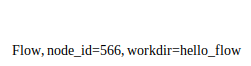

In [113]:
hello_flow.get_graphviz()

#### We also need a function returning two inputs for SCF/NSCF run:

In [114]:
def make_scf_nscf_inputs():
    """
    Build and return two input files for the GS-SCF and the GS-NSCF tasks.
    """
    multi = abilab.MultiDataset(structure="si.cif", pseudos="14si.pspnc", ndtset=2)

    # Set global variables (dataset1 and dataset2)
    multi.set_vars(ecut=6, nband=8)

    # Dataset 1 (GS-SCF run)
    multi[0].set_kmesh(ngkpt=[8, 8, 8], shiftk=[0, 0, 0])
    multi[0].set_vars(tolvrs=1e-6)

    # Dataset 2 (GS-NSCF run on a k-path)
    kptbounds = [
        [0.5, 0.0, 0.0], # L point
        [0.0, 0.0, 0.0], # Gamma point
        [0.0, 0.5, 0.5], # X point
    ]

    multi[1].set_kpath(ndivsm=6, kptbounds=kptbounds)
    multi[1].set_vars(tolwfr=1e-12)
    
    # Return two input files for the GS and the NSCF run
    scf_input, nscf_input = multi.split_datasets()
    return scf_input, nscf_input

#### In terms of factory functions, similar results can be obtained with:

In [115]:
from abipy.abio.factories import ebands_input
scf_input, nscf_input = ebands_input(structure="si.cif", pseudos="14si.pspnc")

#### To add a *Task* we create an *AbinitInput* and we register it in the flow:

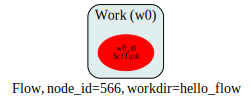

In [116]:
scf_input, nscf_input = make_scf_nscf_inputs()

hello_flow.register_scf_task(scf_input, append=True)
hello_flow.get_graphviz()

#### To select the first *work*:

In [117]:
hello_flow[0]

<Work, node_id=567, workdir=hello_flow/w0>

#### To select the first *task* of the first *work*:

In [118]:
hello_flow[0][0]

<ScfTask, node_id=568, workdir=hello_flow/w0/t0>

### How to define dependencies

* Let's add NSCF calculation that depends on the *scf_task* through the DEN file.
* Dependencies are specified via the {*task*: "file_ext"} dictionary

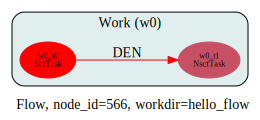

In [119]:
hello_flow.register_nscf_task(nscf_input, deps={hello_flow[0][0]: "DEN"}, 
                              append=True)

hello_flow.get_graphviz(engine="dot")

#### A *Work* is a list of *Tasks* and we can iterate with the syntax:

In [120]:
for task in hello_flow[0]:
    print(task)

<ScfTask, node_id=568, workdir=hello_flow/w0/t0>
<NscfTask, node_id=569, workdir=hello_flow/w0/t1>


### A more complicated dependency:

* We want to add another *NscTask* with a different value of bands

* The new task should read the WFK file produced by *w0_t1* 
  and use the DEN file produced by the first task *w0_t0*

```python
    deps = {hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}
```
    
<!--
Excellent, we managed to build our first AbiPy flow with inter-dependent tasks in just six lines of code (including the three calls to graphviz). 

Well, the syntax for the new deps, it's just:

deps = {hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}
but we should also change the input variable nband in the nscf_input before creating the new NscTask (remember that building a Task requires an AbinitInput object and a list of dependencies, if any).

Now there are two ways to increase nband: the wrong way and the correct one! Let's start from the wrong way because it's always useful to learn from our mistakes. Let's print some values just for the record:
-->

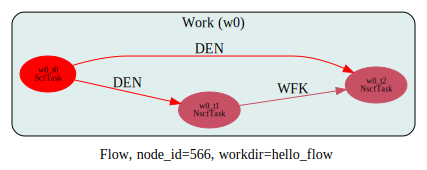

In [121]:
t1 = hello_flow[0][1]

# Copy the input of t1 and change nband
new_input = t1.input.new_with_vars(nband=1000)  

deps = {hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}

hello_flow.register_nscf_task(new_input, deps=deps, append=True)
hello_flow.get_graphviz(engine="dot")

#### Tasks can be connected to external files:

nband in tasks: [8, 10, 20]


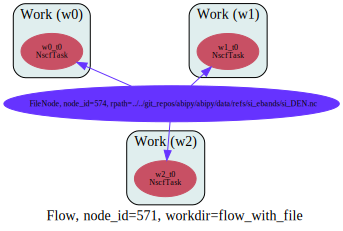

In [122]:
flow_with_file = flowtk.Flow(workdir="flow_with_file")

den_filepath = abidata.ref_file("si_DEN.nc")
flow_with_file.register_nscf_task(nscf_input, deps={den_filepath: "DEN"})

for nband in [10, 20]:
    flow_with_file.register_nscf_task(nscf_input.new_with_vars(nband=nband), 
                                      deps={den_filepath: "DEN"}, append=False)

print("nband in tasks:", [task.input["nband"] for task in flow_with_file.iflat_tasks()])

flow_with_file.get_graphviz()

## Phonon band structure of AlAs

Now we are finally ready for the calculation of the vibrational spectrum of AlAs. 

Once we have a function returning an input for SCF calculations, it's just a matter of 
of passing the SCF input to the *from_scf_input* factory function

In [123]:
def make_scf_input(ecut=2, ngkpt=(4, 4, 4)):
    """
    Generate an `AbinitInput` to perform GS calculation for AlAs.

    Args:
        ecut: Cutoff energy in Ha.
        ngkpt: k-mesh divisions

    Return:
        `AbinitInput` object
    """
    # Initialize the AlAs structure from an internal database. Use the pseudos shipped with AbiPy.
    gs_inp = abilab.AbinitInput(structure="AlAs.cif",
                                pseudos=["13al.pspnc", "33as.pspnc"])

    # Set the value of the Abinit variables needed for GS runs.
    gs_inp.set_vars(
        nband=4,
        ecut=ecut,
        ngkpt=ngkpt,
        nshiftk=4,
        shiftk=[0.0, 0.0, 0.5,   # This gives the usual fcc Monkhorst-Pack grid
                0.0, 0.5, 0.0,
                0.5, 0.0, 0.0,
                0.5, 0.5, 0.5],
        tolvrs=1.0e-10,
    )

    return gs_inp

In [124]:
def build_flow_alas_phonons():
    """
    Build and return a Flow to compute the dynamical matrix on a (2, 2, 2) qmesh
    as well as DDK and Born effective charges.
    The final DDB with all perturbations will be merged automatically and placed
    in the Flow `outdir` directory.
    """
    from abipy import flowtk
    scf_input = make_scf_input(ecut=6, ngkpt=(4, 4, 4))
    return flowtk.PhononFlow.from_scf_input("flow_alas_phonons", scf_input,
                                            ph_ngqpt=(2, 2, 2), with_becs=True)

#####  Abipy will call Abinit to get the list of DFPT perturbations and…

In [125]:
#flow_phbands = build_flow_alas_phonons()
#flow_phbands.get_graphviz()

#### To execute the flow, use the *abirun.py* script:
    
    abirun.py flow_workdir scheduler


For futher info, see 
[this notebook](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/flows.ipynb)

<img src="./assets/abiflows_deps.png" width="85%" align="center">

## DFPT workflows with Abiflows, Fireworks and MongoDB

* Databases makes life easier if one has to handle many calculations
* Databases can be used to 

    * start calculations from previous results
    * save the intermediate status of the jobs
    * store the final results

Building an *Abiflows* workflow for DFPT requires:

In [126]:
#from pseudo_dojo.core.pseudos import OfficialDojoTable
#from abiflows.fireworks.workflows.abinit_workflows import PhononFullFWWorkflow 

# Pseudopotential table from the PseudoDojo package
#pseudo_table = OfficialDojoTable.from_dojodir('ONCVPSP-PBEsol-PDv0.4','standard')

# Create fireworks workflow with default settings
#structure = abilab.Structure.from_file("si.cif")
#wf = PhononFullFWWorkflow.from_factory(structure=structure, pseudos=pseudo_table)

### The dependency graph is similar to the ligthweigh version discussed before:

<img src="./assets/abiflows_workflow.png" width="95%" align="center">

<img src="./assets/fw_model.png" width="25%" align="center">

##### but now one can take advantage of MongoDb to run many calculations in a full automatic way:


```python
from abiflows.fireworks.workflows.abinit_workflows import *
from abiflows.database.mongoengine.utils import DatabaseData
from abiflows.database.mongoengine.abinit_results import RelaxResult
from pseudo_dojo.core.pseudos import OfficialDojoTable

# Pseudopotential Table from PseudoDojo
pseudo_table = OfficialDojoTable.from_dojodir('ONCVPSP-PBEsol-PDv0.4','standard')

# Database with relaxed structures
source_db = DatabaseData(host='database_address', port=27017, 
                         collection='collection_name_used_for_relax', 
                         database='database_used_to_store_relax_calc')

# Database used to store DFPT results.
db = DatabaseData(host='database_address', port=27017, collection='phonon_bs', 
                  database='database_name_eg_phonons')

# Connect to the database
source_db.connect_mongoengine()

# Download relaxed structure from the database.
with source_db.switch_collection(RelaxResult) as RelaxResult:
    relaxed_structure = RelaxResult.objects(mp_id="mp-149")[0].structure

wf = PhononFullFWWorkflow.from_factory(structure=structure, pseudos=pseudo_table)

wf.add_mongoengine_db_insertion(db)
wf.add_final_cleanup(["WFK", "1WF", "WFQ", "1POT", "1DEN"])
wf.add_to_db()
```

<img src="./assets/mongoengine_logo.png" width="50%" align="center">

#### Document-Object Mapper 

   * Like ORM but for document databases
   * Mixins for standard quantities
   * Document associated with workflows
   * Standardized output

abiflows.database.mongoengine modules:

In [127]:
# DateMixin = DirectoryMixin = Document = object

class MaterialMixin(object):
    """
    fields describing the material examined in the calculation
    """

#class PhononResult(MaterialMixin, DateMixin, DirectoryMixin, Document):
#    """
#    results for a phonon workflow
#    """

### How to recostruct AbiPy objects from a MondoDb database
<hr>

```python

from abiflows.database.mongoengine.abinit_results import PhononResult

# Find results for SiC
r = PhononResult.objects(mp_id='mp-8062')[0] 

# Get DDB object from the database.
with r.abinit_output.ddb.abiopen() as ddb: 
    
    # Run anaddb 
    phbst, phdos = ddb.anaget_phbst_and_phdos_files(ngqpt=[8, 8, 5]) 
   
    # Use AbiPy API
    phbst.phbands.plot_with_phdos(phdos.phdos, units='cm-1')
```

## Conclusion

* The *ab-initio* community is migrating to *python* to implement:

    * Pre-processing and post-processing tools
    * Web-based technologies to analyze/visualize data (*e.g.* *jupyter* notebooks …) 
    * High-level logic for scientific workflows and *high-throughput* applications
    
* <u>Difficulties</u> for users:

    * Installation of big software stack (C, C++, Fortran, Python, Javascript …)
    * Multiple technologies under the hood (databases, *JSON*, *HDF5*, *MPI/OMP* …) 
    * Users are supposed to be familiar with programming techniques

* <u>Advantages</u> for users:
    
    * Traditional GUIs are still useful but researchers sometimes need programmatic 
      interfaces to analyze raw data
    * Several *python* packages to boost productivity and do better science


> "An investment in knowledge pays the best interest" (B. Franklin)